<a href="https://colab.research.google.com/github/RXX17/Sentiment-Analysis/blob/main/SentiStudentReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [29]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.1 MB/s 
     |████████████████████████████████| 182 kB 73.3 MB/s 
     |████████████████████████████████| 7.6 MB 57.5 MB/s 


In [1]:
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Helper Functions

In [4]:
import re
from typing import Union, List

class CleanText():
    """ clearing text except digits () . , word character """ 

    def __init__(self, clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğüı'şöç0-9.\"',()]"):
        self.clean_pattern =clean_pattern

    def __call__(self, text: Union[str, list]) -> List[List[str]]:

        if isinstance(text, str):
            docs = [[text]]

        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]

        return text
    
def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text):
    text = regex.sub(" ", text)
    return text

clean = CleanText()

In [5]:
# label encode
def label_encode(x):
    if x == 1 or x == 2:
        return 0
    if x == 3:
        return 1
    if x == 5 or x == 4:
        return 2
    
# label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"

Read Data

In [6]:
df = pd.read_csv("/content/drive/MyDrive/WebTech/MOOC_Reviews1.csv")

In [7]:
df.head()

,Id,Review,Review score,Lable
0,0,good and interesting,5,Positive
1,1,"This class is very helpful to me. Currently, I...",5,Positive
2,2,like!Prof and TAs are helpful and the discussi...,5,Positive
3,3,Easy to follow and includes a lot basic and im...,5,Positive
4,4,Really nice teacher!I could got the point eazl...,4,Positive


In [8]:
df["Lable"].value_counts()

Positive    5406
Neutral     5058
Negative    4710
Name: Lable, dtype: int64

In [9]:
# show column names
print("df.columns: ", df.columns) 

df.columns:  Index(['Id', 'Review', 'Review score', 'Lable'], dtype='object')


In [10]:
df = df[['Review','Review score', 'Lable']]
df.head()

,Review,Review score,Lable
0,good and interesting,5,Positive
1,"This class is very helpful to me. Currently, I...",5,Positive
2,like!Prof and TAs are helpful and the discussi...,5,Positive
3,Easy to follow and includes a lot basic and im...,5,Positive
4,Really nice teacher!I could got the point eazl...,4,Positive


In [11]:
# count of ratings
fig = px.histogram(df,
             x = 'Review score',
             title = 'Histogram of Review Rating',
             template = 'ggplot2',
             color = 'Review score',
             color_discrete_sequence= px.colors.sequential.Blues_r,
             opacity = 0.8,
             height = 525,
             width = 835,
            )

fig.update_yaxes(title='Count')
fig.show()

In [12]:
# basic info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15174 entries, 0 to 15173
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        15174 non-null  object
 1   Review score  15174 non-null  int64 
 2   Lable         15174 non-null  object
dtypes: int64(1), object(2)
memory usage: 355.8+ KB


In [20]:
# encode label and mapping label name
df["label_score"] = df["Review score"].apply(lambda x: label_encode(x))
# df["label_name"] = df["label"].apply(lambda x: label2name(x))

In [13]:
# clean text, lowercase and remove punk
df["Review"] = df["Review"].apply(lambda x: remove_punct(clean(remove_emoji(x).lower())[0][0]))

In [21]:
df.head()

,Review,Review score,Lable,label_score
0,good and interesting,5,Positive,2
1,this class is very helpful to me currently i...,5,Positive,2
2,like prof and tas are helpful and the discussi...,5,Positive,2
3,easy to follow and includes a lot basic and im...,5,Positive,2
4,really nice teacher i could got the point eazl...,4,Positive,2


Data Visualization

In [17]:
# Word Cloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


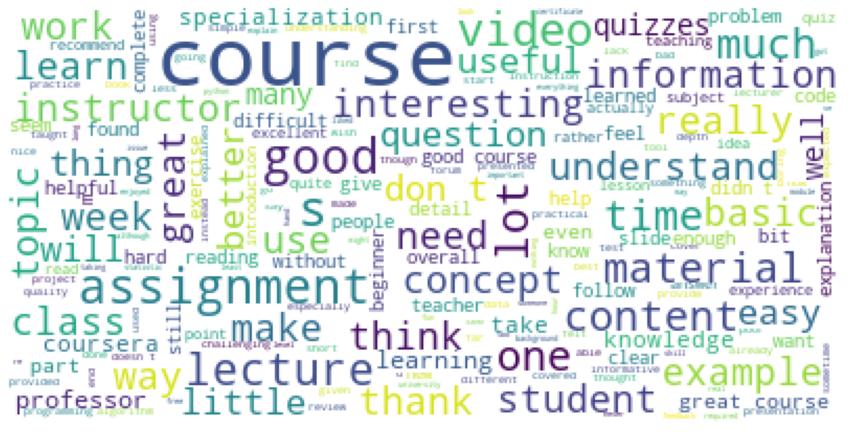

In [18]:
show_wordcloud(df["Review"].values)

In [23]:
# Target Count

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
colors = ['gold', 'mediumturquoise', 'lightgreen'] # darkorange
fig.add_trace(go.Pie(labels=df.Lable.value_counts().index,
                             values=df.label_score.value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=df.Lable.value_counts().index, y=df.label_score.value_counts().values, marker_color = colors), 1,2)

fig.show()

In [24]:
# Token Count with simple Tokenizer

# tokenize data
df["tokenized_review"] = df.Review.apply(lambda x: tokenize(x))
# calculate token count for any sent
df["sent_token_length"] = df["tokenized_review"].apply(lambda x: len(x.split()))

In [25]:
fig = px.histogram(df, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

In [26]:
(df.sent_token_length < 512).mean()

0.9992091735863978

In [30]:
# Token Count with BERT Tokenizer

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [31]:
# data tokenize with bert tokenizer
df["sent_bert_token_length"] = df["Review"].apply(lambda x: len(tokenizer(x, add_special_tokens=False)["input_ids"]))

Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors


In [32]:
fig = px.histogram(df, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

In [33]:
# Less than 512 covers how many of the data
(df.sent_bert_token_length < 512).mean()

0.9991432713852643

Character Count in the data

In [34]:
# valvulate char count for each review
df['char_count'] = df['Review'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 )
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))


    plt.suptitle(f'{title}', fontsize=24)

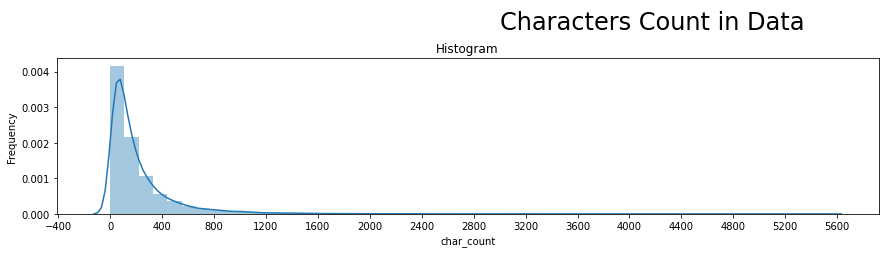

In [35]:
plot_dist3(df, 'char_count',
           'Characters Count in Data')

Length Review

In [36]:
# Creating a new feature for the visualization.
df['Character Count'] = df['Review'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(24, 12))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    plt.suptitle(f'{title}', fontsize=24)

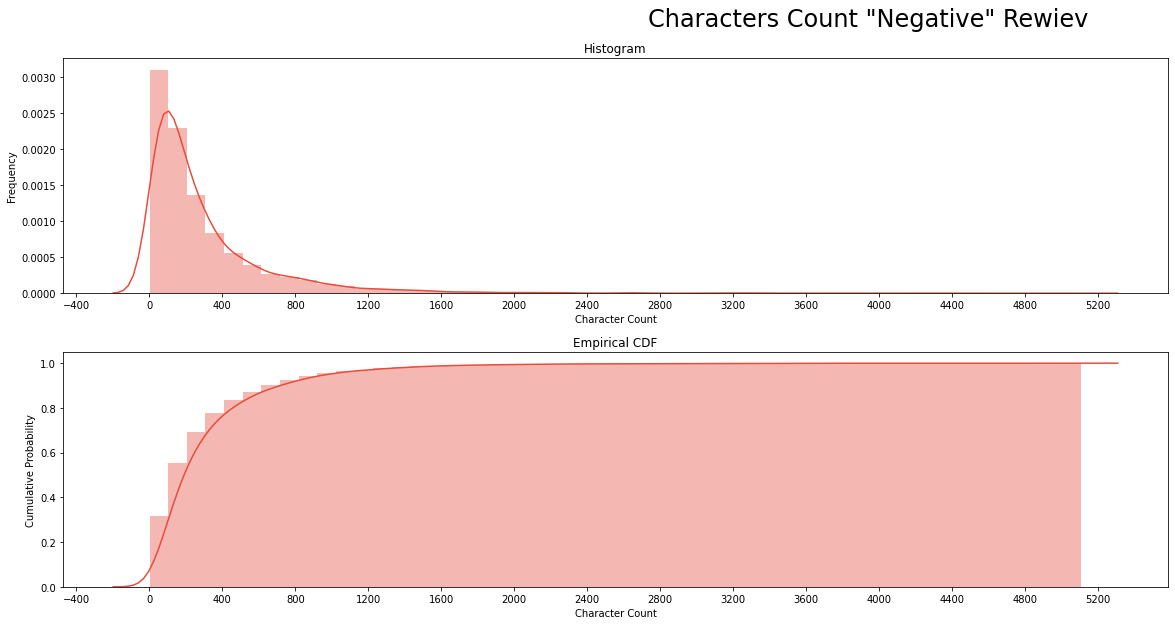

In [37]:
plot_dist3(df[df['label_score'] == 0], 'Character Count',
           'Characters Count "Negative" Rewiev')

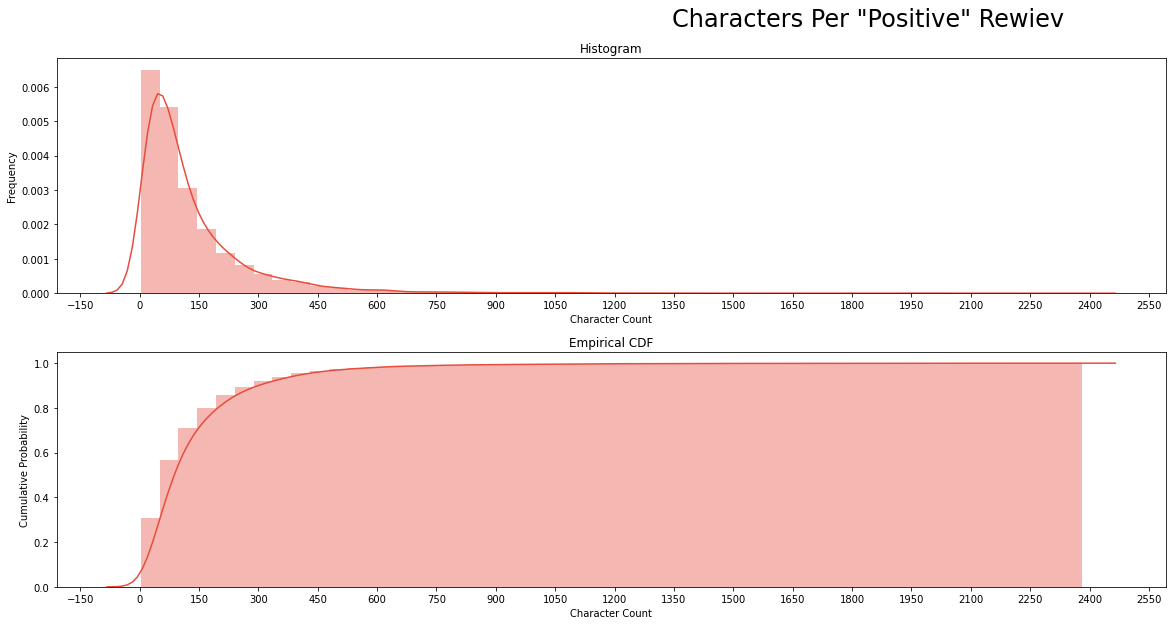

In [38]:
plot_dist3(df[df['label_score'] == 2], 'Character Count',
           'Characters Per "Positive" Rewiev')

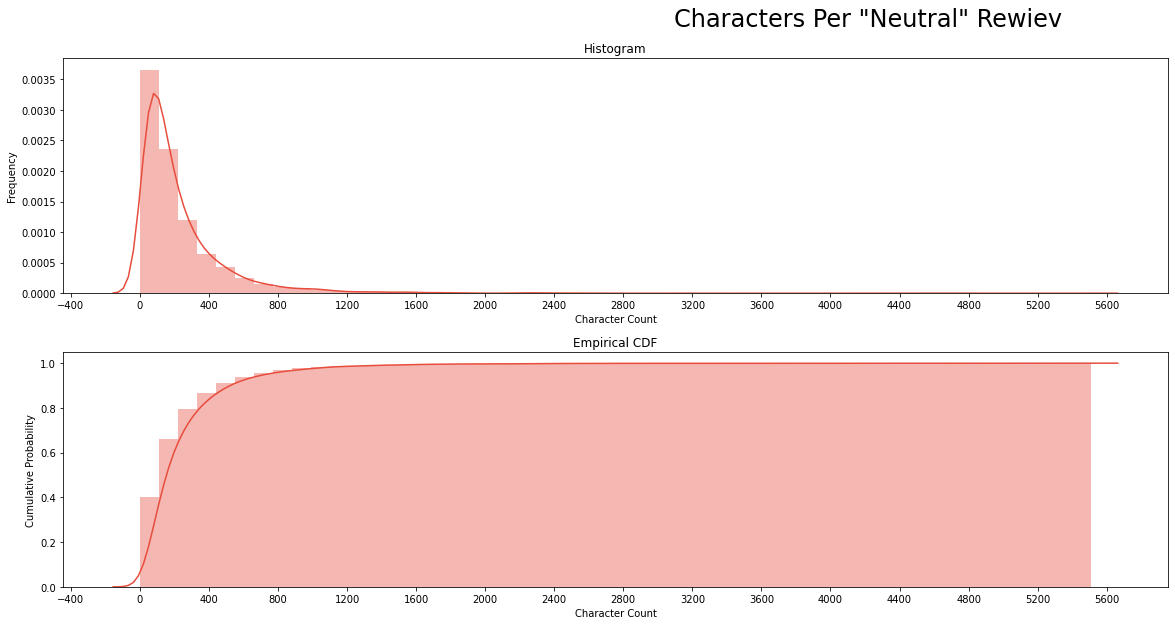

In [39]:
plot_dist3(df[df['label_score'] == 1], 'Character Count',
           'Characters Per "Neutral" Rewiev')

Word Count

In [40]:
def plot_word_number_histogram(textno, textye, textz):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(18, 12), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    sns.distplot(textz.str.split().map(lambda x: len(x)), ax=axes[2], color='#e74c3c')

    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('negative')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('netrual')
    axes[2].set_xlabel('Word Count')
    axes[2].set_title('pozitive')
    
    fig.suptitle('Words Per Review', fontsize=24, va='baseline')
    
    fig.tight_layout()

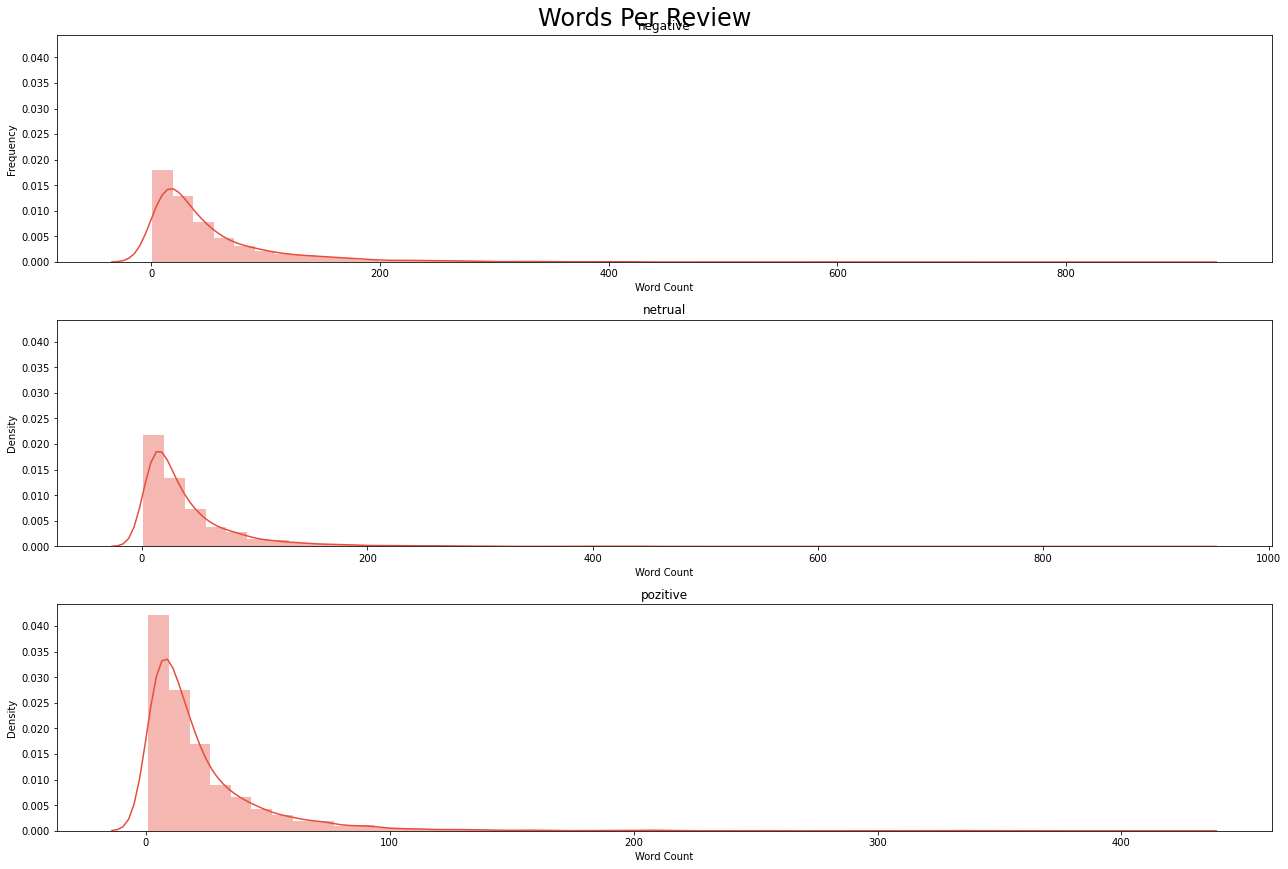

In [41]:
plot_word_number_histogram(df[df['label_score'] == 0]['Review'],
                           df[df['label_score'] == 1]['Review'],
                           df[df['label_score'] == 2]['Review'],
                          )

In [42]:
# remove punk 
df['tokenized_review'] = df['tokenized_review'].apply(lambda x: remove_punct(x))

Most Common words

In [45]:
texts = df['tokenized_review']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:100]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

Most Common ngrams

In [47]:
fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label_score"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:100]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show()

In [48]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

In [49]:
# unigram
fig = make_subplots(rows=1, cols=3)

title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label_score"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))


    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common unigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))      
fig.show()

In [50]:
#trigram

fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label_score"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    top_n_bigrams = _get_top_ngram(texts, 3)[:15]
    x, y = map(list, zip(*top_n_bigrams))

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1),

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common trigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))
    
fig.show()

**Model Building**

BERT Preprocessing

In [51]:
import pandas as pd
import numpy as np
import os
import random
from pathlib import Path
import json

In [52]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [53]:
class Config():
    seed_val = 17
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 5 
    batch_size = 6
    seq_length = 512
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'bert-base-uncased'
    test_size=0.15
    random_state=42
    add_special_tokens=True 
    return_attention_mask=True 
    pad_to_max_length=True 
    do_lower_case=False
    return_tensors='pt'

config = Config()

In [54]:
# params will be saved after training
params = {"seed_val": config.seed_val,
    "device":str(config.device),
    "epochs":config.epochs, 
    "batch_size":config.batch_size,
    "seq_length":config.seq_length,
    "lr":config.lr,
    "eps":config.eps,
    "pretrained_model": config.pretrained_model,
    "test_size":config.test_size,
    "random_state":config.random_state,
    "add_special_tokens":config.add_special_tokens,
    "return_attention_mask":config.return_attention_mask,
    "pad_to_max_length":config.pad_to_max_length,
    "do_lower_case":config.do_lower_case,
    "return_tensors":config.return_tensors,
         }

In [55]:
# set random seed and device
import random

device = config.device

random.seed(config.seed_val)
np.random.seed(config.seed_val)
torch.manual_seed(config.seed_val)
torch.cuda.manual_seed_all(config.seed_val)

In [56]:
df.head()

,Review,Review score,Lable,label_score,tokenized_review,sent_token_length,sent_bert_token_length,char_count,Character Count
0,good and interesting,5,Positive,2,good and interesting,3,3,20,20
1,this class is very helpful to me currently i...,5,Positive,2,this class is very helpful to me currently i m...,23,23,121,121
2,like prof and tas are helpful and the discussi...,5,Positive,2,like prof and tas are helpful and the discussi...,18,20,117,117
3,easy to follow and includes a lot basic and im...,5,Positive,2,easy to follow and includes a lot basic and im...,14,15,81,81
4,really nice teacher i could got the point eazl...,4,Positive,2,really nice teacher i could got the point eazl...,12,15,58,58


In [58]:
# Train Validation Split

#split train test
from sklearn.model_selection import train_test_split

train_df_, val_df = train_test_split(df, 
                                    test_size=0.10, 
                                    random_state=config.random_state, 
                            stratify=df.label_score.values)

In [59]:
train_df_.head()

,Review,Review score,Lable,label_score,tokenized_review,sent_token_length,sent_bert_token_length,char_count,Character Count
7901,the information in the videos was very interes...,2,Negative,0,the information in the videos was very interes...,82,83,490,490
2140,work with real industry data is so much fun,4,Positive,2,work with real industry data is so much fun,9,9,44,44
14077,the course tests are at times partially unrela...,1,Negative,0,the course tests are at times partially unrela...,169,173,859,859
43,progress is in a state of flux so one must re...,5,Positive,2,progress is in a state of flux so one must rea...,45,45,227,227
11450,it is intresting course,3,Neutral,1,it is intresting course,4,6,23,23


In [60]:
train_df, test_df = train_test_split(train_df_, 
                                    test_size=0.10, 
                                    random_state=42, 
                            stratify=train_df_.label_score.values)

In [61]:
# count of unique label  control 
print(len(train_df['label_score'].unique()))
print(train_df.shape)

3
(12290, 9)


In [62]:
# count of unique label  control 
print(len(val_df['label_score'].unique()))
print(val_df.shape)

3
(1518, 9)


In [63]:
print(len(test_df['label_score'].unique()))
print(test_df.shape)

3
(1366, 9)


In [64]:
# BERT Tokenizer and encoding

# create tokenizer
tokenizer = BertTokenizer.from_pretrained(config.pretrained_model, 
                                          do_lower_case=config.do_lower_case)

In [65]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df.Review.values, 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length, 
    max_length=config.seq_length, 
    return_tensors=config.return_tensors
)
encoded_data_val = tokenizer.batch_encode_plus(
    val_df.Review.values, 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length, 
    return_tensors=config.return_tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [66]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.label_score.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.label_score.values)

In [67]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [68]:
# Creating Model

model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [69]:
# Data Loaders

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=config.batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=config.batch_size)

In [70]:
# Optimizer and Scheduler

from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=config.lr, 
                  eps=config.eps)
                  

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*config.epochs)

In [71]:
# Performance Metrics

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [72]:
# Training Loop

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(config.device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
    # calculate avareage val loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [73]:
config.device

device(type='cuda', index=0)

In [74]:
model.to(config.device)
    
for epoch in tqdm(range(1, config.epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    # allows you to see the progress of the training 
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(config.device) for b in batch)
        
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    
    tqdm.write(f'F1 Score (Weighted): {val_f1}');
# save model params and other configs 
with Path('params.json').open("w") as f:
    json.dump(params, f, ensure_ascii=False, indent=4)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2049 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6372533763566574
Validation loss: 0.5626955116572587
F1 Score (Weighted): 0.7586282850639515


Epoch 2:   0%|          | 0/2049 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.4767152690519558
Validation loss: 0.6571872962064481
F1 Score (Weighted): 0.7667322564684047


Epoch 3:   0%|          | 0/2049 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.34484138066866543
Validation loss: 0.9264943436756289
F1 Score (Weighted): 0.766058125451775


Epoch 4:   0%|          | 0/2049 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.22331469607509477
Validation loss: 1.3223682397727121
F1 Score (Weighted): 0.7545210730866787


Epoch 5:   0%|          | 0/2049 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.13285024651805366
Validation loss: 1.4905327521353129
F1 Score (Weighted): 0.7566392494976321


In [75]:
# Test on Validation set

model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [76]:
from sklearn.metrics import classification_report

preds_flat = np.argmax(predictions, axis=1).flatten()
print(classification_report(preds_flat, true_vals))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       462
           1       0.67      0.65      0.66       527
           2       0.87      0.89      0.88       529

    accuracy                           0.76      1518
   macro avg       0.75      0.75      0.75      1518
weighted avg       0.75      0.76      0.75      1518



In [77]:
# Error Analysis

# step by step predictions on dataframe
# We do this to view predictions in the pandas dataframe and easily filter them and perform error analysis.

pred_final = []

for i, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    predictions = []

    review = row["Review"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review], 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length, 
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

    
    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/1518 [00:00<?, ?it/s]

In [78]:
# add pred into val_df
val_df["pred"] = pred_final

In [80]:
#  Add control column for easier wrong and right predictions
control = val_df.pred.values == val_df.label_score.values
val_df["control"] = control

In [81]:
# filtering false predictions
val_df = val_df[val_df.control == False]

In [82]:
# buraları düzenle bbaaaabbaaaaa
# label to intent mapping
name2label = {"Negative":0,
              "Neutral":1,
             "Positive":2
             }
label2name = {v: k for k, v in name2label.items()}

val_df["pred_name"] = val_df.pred.apply(lambda x: label2name.get(x)) 

In [85]:
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = val_df.pred_name.values
label_values = val_df.Lable.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [86]:
confmat

array([[  0, 147,  10],
       [ 81,   0,  45],
       [  7,  68,   0]])

In [87]:
df_confusion_val = pd.crosstab(label_values, pred_name_values)
df_confusion_val

col_0,Negative,Neutral,Positive
row_0,,,
Negative,0,147,10
Neutral,81,0,45
Positive,7,68,0


In [88]:
# save confissuan matrix df
df_confusion_val.to_csv("val_df_confusion.csv")

In [89]:
# Inference

test_df.head()

,Review,Review score,Lable,label_score,tokenized_review,sent_token_length,sent_bert_token_length,char_count,Character Count
773,after completing this course i have gained va...,5,Positive,2,after completing this course i have gained val...,68,68,395,395
1623,awesome course,5,Positive,2,awesome course,2,2,15,15
14170,is not as bad as i thought at the beginning t...,3,Neutral,1,is not as bad as i thought at the beginning th...,27,27,139,139
5728,great course to follow along i love how the h...,4,Positive,2,great course to follow along i love how the ho...,25,25,140,140
2066,it is a very good course to understand the bas...,5,Positive,2,it is a very good course to understand the bas...,17,18,99,99


In [90]:
encoded_data_test = tokenizer.batch_encode_plus(
    test_df.Review.values, 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length, 
    return_tensors=config.return_tensors
)

In [91]:
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_df.label_score.values)

In [92]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(config.device)

model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

_, predictions_test, true_vals_test = evaluate(dataloader_validation)
# accuracy_per_class(predictions, true_vals, intent2label)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [93]:
from sklearn.metrics import classification_report

preds_flat_test = np.argmax(predictions_test, axis=1).flatten()
print(classification_report(preds_flat_test, true_vals_test))

              precision    recall  f1-score   support

           0       0.67      0.78      0.72       402
           1       0.75      0.64      0.69       595
           2       0.86      0.89      0.88       521

    accuracy                           0.76      1518
   macro avg       0.76      0.77      0.76      1518
weighted avg       0.77      0.76      0.76      1518



In [94]:
pred_final = []

for i, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    predictions = []

    review = row["Review"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review], 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length, 
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

    
    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/1366 [00:00<?, ?it/s]

In [95]:
# add pred into test
test_df["pred"] = pred_final

In [96]:
#  Add control column for easier wrong and right predictions
control = test_df.pred.values == test_df.label_score.values
test_df["control"] = control

In [97]:
# filtering false predictions
test_df = test_df[test_df.control == False]

In [98]:
test_df["pred_name"] = test_df.pred.apply(lambda x: label2name.get(x)) 

In [99]:
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = test_df.pred_name.values
label_values = test_df.Lable.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [100]:
confmat

array([[  0, 146,  12],
       [ 78,   0,  58],
       [  4,  70,   0]])

In [101]:
df_confusion_test = pd.crosstab(label_values, pred_name_values)
df_confusion_test

col_0,Negative,Neutral,Positive
row_0,,,
Negative,0,146,12
Neutral,78,0,58
Positive,4,70,0
